Plot the Percession phase distribution on Earth

In [23]:
!pip install selenium

     ---------------------------------------- 6.5/6.5 MB 5.5 MB/s eta 0:00:00
     ------------------------------------- 384.9/384.9 kB 12.1 MB/s eta 0:00:00
     ---------------------------------------- 58.3/58.3 kB 3.2 MB/s eta 0:00:00


In [14]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

#function to get insolation data from the website http://vo.imcce.fr/insola/earth/online/earth/online/index.php
def get_inso_dat(f_startingtime=-1, f_endingtime=0, f_steptime=1000, lat_earth=65, lon_orbit=90):
    # Set up the browser
    browser = webdriver.Chrome()

    # Navigate to the website
    url = 'http://vo.imcce.fr/insola/earth/online/earth/online/index.php'
    browser.get(url)

    f_startingtime=f_startingtime
    f_endingtime=f_endingtime
    f_steptime=f_steptime
    #f_so=1368
    f_insolation=1
    # insotype="2"
    f_latitude=lat_earth
    f_longitude=lon_orbit


    # Fill in the parameters
    start_input = browser.find_element(By.NAME, 'f_startingtime')
    start_input.clear()
    start_input.send_keys(f_startingtime)

    end_input = browser.find_element(By.NAME, 'f_endingtime')
    end_input.clear()
    end_input.send_keys(f_endingtime)

    step_input = browser.find_element(By.NAME, 'f_steptime')
    step_input.clear()
    step_input.send_keys(f_steptime)

    # constant_input = browser.find_element(By.NAME, 'f_so')
    # constant_input.clear()
    # constant_input.send_keys(f_so)

    datatype_input = browser.find_element(By.NAME, 'f_insolation')
    datatype_input.send_keys(f_insolation)

    insotype_input = browser.find_element(By.XPATH, '//input[@name="f_typeinsolation" and @value="2"]')
    insotype_input.click()

    lat_input = browser.find_element(By.NAME, 'f_latitude')
    lat_input.send_keys(f_latitude)

    lon_input = browser.find_element(By.NAME, 'f_longitude')
    lon_input.send_keys(f_longitude)

    # Click the Compute button
    compute_button = browser.find_element(By.XPATH, '//input[@value="Compute"]')
    compute_button.click()

    # Wait for the pop-up window to appear and switch to it
    popup_window = WebDriverWait(browser, 10).until(EC.number_of_windows_to_be(2))
    browser.switch_to.window(browser.window_handles[1])

    # Get the text content of the pop-up window
    text_content = browser.find_element(By.XPATH, '/html/body/pre').text


    if f_latitude>0:
        filename=f'inso{f_latitude}N{abs(f_startingtime)}Ma_to{abs(f_endingtime)}Ma_step{f_steptime}yr'
    else:
        filename=f'inso{abs(f_latitude)}S{abs(f_startingtime)}Ma_to{abs(f_endingtime)}Ma_step{f_steptime}yr'
    filepath = f'D:/VScode/NS_syn/data/{filename}.txt'
    # Save the text content as a text file
    with open(filepath, 'w') as f:
        f.write(text_content)

    # Close the pop-up window and switch back to the main window
    browser.close()
    browser.switch_to.window(browser.window_handles[0])

    # Close the browser
    browser.quit()



In [11]:
def gen_file_name(path='D:/VScode/NS_syn/data/',f_latitude=65,f_startingtime=-1,f_endingtime=0,f_steptime=1000):
    if f_latitude>0:
        filename=f'inso{f_latitude}N{abs(f_startingtime)}Ma_to{abs(f_endingtime)}Ma_step{f_steptime}yr'
    else:
        filename=f'inso{abs(f_latitude)}S{abs(f_startingtime)}Ma_to{abs(f_endingtime)}Ma_step{f_steptime}yr'
    filepath = f'{path}{filename}.txt'
    return filepath

In [16]:
# call the functiona and get the insolation data
import os
f_startingtime=-1
f_endingtime=0
f_steptime=1000

for i in range(-80, 81, 10):
    #check whether file exists, if not, get the data
    filepath=gen_file_name(f_latitude=i,f_startingtime=f_startingtime,f_endingtime=f_endingtime,f_steptime=f_steptime)
    if os.path.isfile(filepath):
        continue
    else:
        get_inso_dat(f_startingtime=f_startingtime, f_endingtime=f_endingtime, f_steptime=f_steptime, lat_earth=i, lon_orbit=90)

In [54]:
import xarray as xr
import pandas as pd
import os
import glob

# Define file path and pattern
file_pattern = 'D:/VScode/NS_syn/data/*.txt'

# Get a list of file paths that match the pattern
file_list = sorted([os.path.abspath(file) for file in glob.glob(file_pattern)])
file_list = [file.replace('\\', '/') for file in file_list]

# Create an empty list to store each pandas DataFrame
df_list = []

# Loop over each file, read it with pandas, and append to the list
for file in file_list:
    df = pd.read_csv(file, sep='    ', header=None, names=['time', 'insolation'],engine='python',skipfooter=1)
    df_list.append(df)

# Concatenate all DataFrames into a single pandas DataFrame
df = pd.concat(df_list, keys=file_list)

# Convert the pandas DataFrame to an xarray dataset
ds = xr.Dataset.from_dataframe(df)

ds = ds.rename_dims({'level_0': 'data_file', 'level_1': 'rows'})


In [55]:
ds

<xarray.Dataset>
Dimensions:     (data_file: 18, rows: 1000)
Coordinates:
  * level_0     (data_file) object 'D:/VScode/NS_syn/data/inso0S1Ma_to0Ma_ste...
  * level_1     (rows) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Dimensions without coordinates: data_file, rows
Data variables:
    time        (data_file, rows) float64 -1e+03 -999.0 -998.0 ... -2.0 -1.0
    insolation  (data_file, rows) float64 428.0 424.7 418.9 ... 0.0 0.0 0.0

In [23]:
import xarray as xr

# Define file path and pattern
file_pattern = 'D:/VScode/NS_syn/data/*.txt'  # replace with actual path to your files

# Read all files into an xarray dataset
ds = xr.open_mfdataset(file_pattern, engine='pandas', delim_whitespace=True, header=None, names=['time', 'insolation'])

# Print the resulting dataset
print(ds)

ValueError: unrecognized engine pandas must be one of: ['netcdf4', 'scipy', 'store']

In [9]:
import numpy as np

# Read text data from file
with open('D:/VScode/NS_syn/data/inso65N1Ma_to0Ma_step1000yr.txt', 'r') as f:
    data = f.readlines()

# Convert data to ndarray
data_array = np.array(data)

data_array


array(['   -1000.000     535.040268\n', '    -999.000     533.371422\n',
       '    -998.000     527.740851\n', ...,
       '      -2.000     483.958944\n', '      -1.000     481.433762\n',
       '       0.000     480.368585'], dtype='<U28')

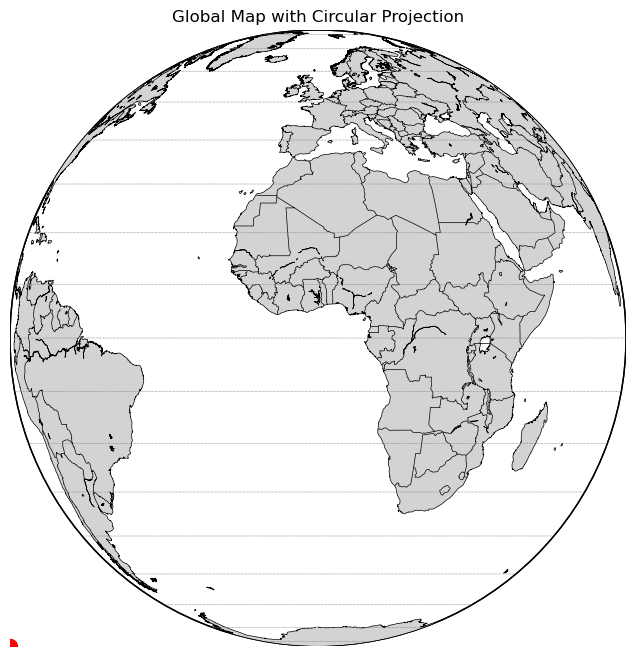

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# Create a new map figure
fig = plt.figure(figsize=(8, 8),dpi=100)

# Create a Basemap instance with Orthographic projection centered at (0, 0)
m = Basemap(projection='ortho', lat_0=0, lon_0=0, resolution='l')

# Draw the coastlines, countries, and oceans
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

# Draw horizontal lines for each 10 degree latitude
#m.drawparallels(range(-90, 91, 10), labels=[1,0,0,0], fontsize=10)
m.drawparallels(np.arange(-90.,91.,10.),linestyle='-',color='gray',linewidth=0.5)
plt.scatter(0, 0, marker='o', color='red', s=100, zorder=10)

# Add a title
plt.title('Global Map with Circular Projection')

# Show the plot
plt.show()


c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


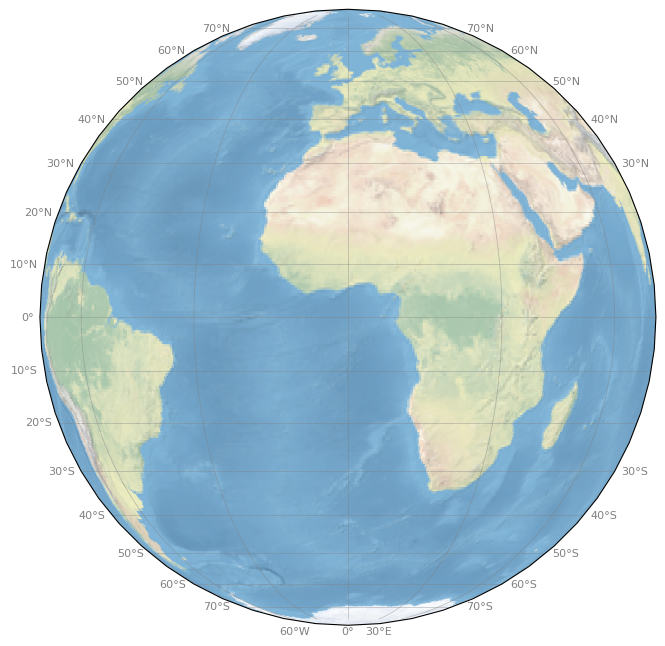

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create an Orthographic projection
proj = ccrs.Orthographic(central_longitude=0, central_latitude=0)

# Create a figure with a Cartopy projection
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.stock_img()

# # Add land, ocean, and coastline features to the map
# ax.add_feature(cfeature.LAND, edgecolor='black')
# ax.add_feature(cfeature.OCEAN, edgecolor='black')
# ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Set the extent of the map to be a circle
ax.set_global()

# Add gridlines with latitude labels only
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 30))
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 8, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'gray'}

# Show the plot
plt.show()


c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


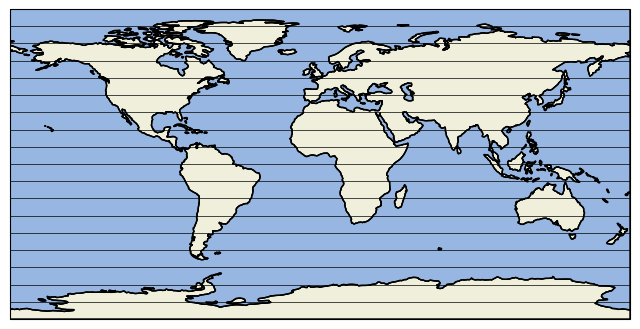

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a PlateCarree projection centered on 0 degrees longitude
proj = ccrs.PlateCarree(central_longitude=0)

# Create a figure with a Cartopy projection
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add land, ocean, and coastline features to the map
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Set the extent of the map to be a circle
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Plot horizontal lines for each 10 degrees latitude
for lat in range(-90, 91, 10):
    ax.plot([-180, 180], [lat, lat], color='black', linewidth=0.5, transform=ccrs.PlateCarree())

# Show the plot
plt.show()


In [21]:
!pip install pyppeteer

In [22]:
import asyncio
from pyppeteer import launch

async def main():
    # Launch the browser
    browser = await launch(headless=True)

    # Create a new page and navigate to the website
    page = await browser.newPage()
    await page.goto('http://vo.imcce.fr/insola/earth/online/earth/online/index.php')

    # Fill in the form data
    f_startingtime=-2
    f_endingtime=1
    f_steptime=1000
    f_insolation=1
    f_latitude=65
    f_longitude=90

    await page.type('input[name="f_startingtime"]', str(f_startingtime))
    await page.type('input[name="f_endingtime"]', str(f_endingtime))
    await page.type('input[name="f_steptime"]', str(f_steptime))
    await page.select('select[name="f_insolation"]', str(f_insolation))
    await page.click('input[name="f_typeinsolation"][value="2"]')
    await page.type('input[name="f_latitude"]', str(f_latitude))
    await page.type('input[name="f_longitude"]', str(f_longitude))

    # Submit the form
    await page.click('input[value="Compute"]')

    # Wait for the results to load
    await page.waitForSelector('pre')

    # Get the text content of the results
    text_content = await page.evaluate('() => document.querySelector("pre").textContent')

    # Save the text content to a file
    if f_latitude>0:
        filename=f'inso{f_latitude}N{abs(f_startingtime)}Ma_to{abs(f_endingtime)}Ma_step{f_steptime}yr'
    else:
        filename=f'inso{abs(f_latitude)}S{abs(f_startingtime)}Ma_to{abs(f_endingtime)}Ma_step{f_steptime}yr'

    with open(f'D:/VScode/NS_pre_syn/data/{filename}.txt', 'w') as f:
        f.write(text_content)

    # Close the browser
    await browser.close()

# Run the main function
asyncio.get_event_loop().run_until_complete(main())


RuntimeError: This event loop is already running

In [20]:
import requests

# Set up the request URL and form data
url = 'http://vo.imcce.fr/insola/earth/online/earth/online/index.php'
form_data = {
    'f_startingtime': '-2',
    'f_endingtime': '1',
    'f_steptime': '1000',
    'f_insolation': '1',
    'f_latitude': '65',
    'f_longitude': '90',
    'submit': 'Compute'
}

# Make the POST request and get the response content
response = requests.post(url, data=form_data)
text_content = response.content.decode()

# Determine the file name based on the latitude and time range
f_latitude = int(form_data['f_latitude'])
f_startingtime = abs(int(form_data['f_startingtime']))
f_endingtime = abs(int(form_data['f_endingtime']))
f_steptime = int(form_data['f_steptime'])
if f_latitude > 0:
    filename = f'inso{f_latitude}N{f_startingtime}Ma_to{f_endingtime}Ma_step{f_steptime}yr'
else:
    filename = f'inso{abs(f_latitude)}S{f_startingtime}Ma_to{f_endingtime}Ma_step{f_steptime}yr'
filepath = f'D:/VScode/NS_pre_syn/data/{filename}.txt'

# Save the response content as a text file
with open(filepath, 'w') as f:
    f.write(text_content)


In [19]:
import requests

# Set up the URL and form data
url = 'http://vo.imcce.fr/insola/earth/online/earth/online/plot.php'
data = {
    'f_startingtime': '-2',
    'f_endingtime': '1',
    'f_steptime': '1000',
    'f_insolation': '1',
    #'f_typeinsolation': '2',
    'f_latitude': '65',
    'f_longitude': '90',
    'afficher': 'Compute'
}

# Make the HTTP POST request
response = requests.post(url, data=data)

# Get the response content as text
text_content = response.text

if int(data['f_latitude']) > 0:
    filename = f'inso{data["f_latitude"]}N{abs(int(data["f_startingtime"]))}Ma_to{abs(int(data["f_endingtime"]))}Ma_step{int(data["f_steptime"])}yr'
else:
    filename = f'inso{abs(int(data["f_latitude"]))}S{abs(int(data["f_startingtime"]))}Ma_to{abs(int(data["f_endingtime"]))}Ma_step{int(data["f_steptime"])}yr'

filepath = f'D:/VScode/NS_pre_syn/data/{filename}.txt'
# Save the text content as a text file
with open(filepath, 'w') as f:
    f.write(text_content)


In [38]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Set up the browser
browser = webdriver.Chrome()

# Navigate to the website
url = 'http://vo.imcce.fr/insola/earth/online/earth/online/index.php'
browser.get(url)

# Fill in the parameters
start_input = browser.find_element(By.NAME, 'f_startingtime')
start_input.clear()
start_input.send_keys('-2')

end_input = browser.find_element(By.NAME, 'f_endingtime')
end_input.clear()
end_input.send_keys('1')

step_input = browser.find_element(By.NAME, 'f_steptime')
step_input.clear()
step_input.send_keys('1000')

constant_input = browser.find_element(By.NAME, 'f_so')
constant_input.clear()
constant_input.send_keys('1368')

datatype_input = browser.find_element(By.NAME, 'f_insolation')
# lon_input.clear()
datatype_input.send_keys('1')

insotype_input = browser.find_element(By.NAME, 'f_typeinsolation')
# insotype_input.clear()
insotype_input.click()
# insotype_input.send_keys('2')

lat_input = browser.find_element(By.NAME, 'f_latitude')
# lat_input.clear()
lat_input.send_keys('65')

lon_input = browser.find_element(By.NAME, 'f_longitude')
# lon_input.clear()
lon_input.send_keys('90')
# Click the Compute button
compute_button = browser.find_element(By.XPATH, '//input[@value="Compute"]')
compute_button.click()

# Wait for the pop-up window to appear and switch to it
popup_window = WebDriverWait(browser, 10).until(EC.number_of_windows_to_be(2))
browser.switch_to.window(browser.window_handles[1])

# Download the text file
download_link = browser.find_element(By.LINK_TEXT, 'here')
download_link.click()

# Switch back to the main window
browser.switch_to.window(browser.window_handles[0])

# Close the browser
browser.quit()

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"link text","selector":"here"}
  (Session info: chrome=111.0.5563.147)
Stacktrace:
Backtrace:
	(No symbol) [0x0097DCE3]
	(No symbol) [0x009139D1]
	(No symbol) [0x00824DA8]
	(No symbol) [0x0085019F]
	(No symbol) [0x008503AB]
	(No symbol) [0x0087EE62]
	(No symbol) [0x0086AF14]
	(No symbol) [0x0087D57C]
	(No symbol) [0x0086ACC6]
	(No symbol) [0x00846F68]
	(No symbol) [0x008480CD]
	GetHandleVerifier [0x00BF3832+2506274]
	GetHandleVerifier [0x00C29794+2727300]
	GetHandleVerifier [0x00C2E36C+2746716]
	GetHandleVerifier [0x00A26690+617600]
	(No symbol) [0x0091C712]
	(No symbol) [0x00921FF8]
	(No symbol) [0x009220DB]
	(No symbol) [0x0092C63B]
	BaseThreadInitThunk [0x76F37D69+25]
	RtlInitializeExceptionChain [0x77CAB74B+107]
	RtlClearBits [0x77CAB6CF+191]


In [37]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Set up the browser
browser = webdriver.Chrome()

# Navigate to the website
url = 'http://vo.imcce.fr/insola/earth/online/earth/online/index.php'
browser.get(url)

# Fill in the parameters
start_input = browser.find_element(By.NAME, 'f_startingtime')
start_input.clear()
start_input.send_keys('-2')

end_input = browser.find_element(By.NAME, 'f_endingtime')
end_input.clear()
end_input.send_keys('1')

step_input = browser.find_element(By.NAME, 'f_steptime')
step_input.clear()
step_input.send_keys('1000')

constant_input = browser.find_element(By.NAME, 'f_so')
constant_input.clear()
constant_input.send_keys('1368')

datatype_input = browser.find_element(By.NAME, 'f_insolation')
# lon_input.clear()
datatype_input.send_keys('1')

insotype_input = browser.find_element(By.NAME, 'f_typeinsolation')
# insotype_input.clear()
insotype_input.click()
# insotype_input.send_keys('2')

lat_input = browser.find_element(By.NAME, 'f_latitude')
# lat_input.clear()
lat_input.send_keys('65')

lon_input = browser.find_element(By.NAME, 'f_longitude')
# lon_input.clear()
lon_input.send_keys('90')


# insolation_checkbox = browser.find_element(By.NAME, 'f_insolation')
# insolation_checkbox.click()

# daily_insolation_checkbox = browser.find_element(By.NAME, 'mean daily insolation / true longitude')
# daily_insolation_checkbox.click()

# Click the Compute button
compute_button = browser.find_element(By.XPATH, '//input[@value="Compute"]')
# compute_button.click()

# Wait for the pop-up window to appear and switch to it
popup_window = WebDriverWait(browser, 10).until(EC.number_of_windows_to_be(2))
browser.switch_to.window(browser.window_handles[1])

# Get the HTML content of the pop-up window
popup_html = browser.page_source

# Parse the HTML using BeautifulSoup
soup = BeautifulSoup(popup_html, 'html.parser')

# Find the table containing the insolation data
table = soup.find('table', {'class': 'display'})
if table is not None:
    # Extract the insolation data from the table rows
    data = []
    for row in table.find_all('tr')[1:]:
        cols = row.find_all('td')
        date = cols[0].text.strip()
        insolation = float(cols[1].text.strip())
        data.append((date, insolation))

    # Print the extracted data
    print(data)
else:
    print('Table not found')

# Close the pop-up window and switch back to the main window
browser.close()
browser.switch_to.window(browser.window_handles[0])

# Close the browser
browser.quit()

TimeoutException: Message: 


In [24]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Set up the browser
browser = webdriver.Chrome()

# Navigate to the website
url = 'http://vo.imcce.fr/insola/earth/online/earth/online/index.php'
browser.get(url)

# Find the button you want to click
button = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.XPATH, '//button[@class="my-button-class"]')))

# Click the button
button.click()

# Wait for the new page to load
new_page_loaded = WebDriverWait(browser, 10).until(EC.url_changes(url))

if new_page_loaded:
    print('Clicked the button successfully and a new page was loaded')
else:
    print('Button click failed or no new page was loaded')

# Close the browser
browser.quit()

TimeoutException: Message: 
Stacktrace:
Backtrace:
	(No symbol) [0x0097DCE3]
	(No symbol) [0x009139D1]
	(No symbol) [0x00824DA8]
	(No symbol) [0x0085019F]
	(No symbol) [0x008503AB]
	(No symbol) [0x0087EE62]
	(No symbol) [0x0086AF14]
	(No symbol) [0x0087D57C]
	(No symbol) [0x0086ACC6]
	(No symbol) [0x00846F68]
	(No symbol) [0x008480CD]
	GetHandleVerifier [0x00BF3832+2506274]
	GetHandleVerifier [0x00C29794+2727300]
	GetHandleVerifier [0x00C2E36C+2746716]
	GetHandleVerifier [0x00A26690+617600]
	(No symbol) [0x0091C712]
	(No symbol) [0x00921FF8]
	(No symbol) [0x009220DB]
	(No symbol) [0x0092C63B]
	BaseThreadInitThunk [0x76F37D69+25]
	RtlInitializeExceptionChain [0x77CAB74B+107]
	RtlClearBits [0x77CAB6CF+191]


In [21]:
import requests
from bs4 import BeautifulSoup

# Define the URL of the website
url = 'http://vo.imcce.fr/insola/earth/online/earth/online/index.php'

# Define the parameters to be sent in the request
params = {
    'f_startingtime': '-1',
    'f_endingtime': '1',
    'f_steptime': '1000',
    'f_so': '1368',
    'f_insolation':'1',
    'f_typeinsolation': '1',
    'f_latitude': '45',
    'f_longitude': '-75',
    'Compute':'1'

}



# fill in the form on the url uising params
response = requests.post(url)
data = response.content.decode('utf-8')
print(response.text)


# # Send a GET request with the parameters
# response = requests.get(url, params=params,allow_redirects=True)

# # Parse the HTML response using BeautifulSoup
# soup = BeautifulSoup(response.content, 'html.parser')

# # Find the table containing the insolation data
# table = soup.find('table', {'class': 'display'})
# if table is not None:
#     # Extract the insolation data from the table rows
#     data = []
#     for row in table.find_all('tr')[1:]:
#         cols = row.find_all('td')
#         date = cols[0].text.strip()
#         insolation = float(cols[1].text.strip())
#         data.append((date, insolation))

#     # Print the extracted data
#     print(data)
# else:
#     print('Table not found')


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<html xmlns="http://www.w3.org/1999/xhtml">

	<head>
		<meta http-equiv="content-type" content="text/html;charset=utf-8" />
		<meta name="generator" content="Adobe GoLive" />
		<title>Computation of various insolation quantities for Earth</title>
		<style type="text/css">@import url("webasd.css");</style>
		
<script type="text/javascript">

function showMe (it, box) {
var vis = (box.checked) ? "block" : "none";
document.getElementById(it).style.display = vis;
}

function showMeBool(it, booleen) {
var vis = (booleen==false) ? "block" : "none";
document.getElementById(it).style.display =vis;
}


function resultopen(filename)
{
  newwindow=window.open(filename);
  if (newwindow==null || typeof(newwindow)=="undefined") 
  {  
    var d = new Date();
    var t_date = d.getDate();      // Returns the day of the month
    var t_mon = d.getMonth();      // Returns the mont

In [15]:
r


<Response [200]>

In [ ]:
import requests

url = 'http://vo.imcce.fr/insola/earth/online/earth/online/index.php'
params = {
    'starting time': '-1',
    'ending time': '1',
    'sampling step': '1000',
    'solar constant': '1368',
    'latitude': '45',
    'longitude': '-75'
}

response = requests.post(url, data=params)
data = response.content.decode('utf-8')

print(data)